In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import viz

from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from scipy.stats import linregress
from viz import AX_FACECOLOR


colors = viz.plotting_style()
lin_colors = list(colors.values())

plt.style.use('style.mpl')

In [2]:
# Read in a combined dataframe of all the coding sequence NOSC values.
long_nosc_df = pd.read_csv('../data/genomes/all_ref_prot_NOSC.csv')

# Amino acid properties
aa_nosc_df = pd.read_csv('../data/aa_nosc.csv')

# Single files per-organism of proteome level Z_C at different growth rates.
coli_data = pd.read_csv('../data/proteomes/Coli/Chure_proteome_NOSC.csv')
yeast_data = pd.read_csv('../data/proteomes/Scer/Xia_proteome_NOSC.csv')
cyano_data = pd.read_csv('../data/proteomes/Synechocystis/Zavrel_proteome_NOSC.csv')

# Unified file of the protein-level measurements.
all_expression_data = pd.read_csv('../data/proteomes/all_protein_measurements.csv')

/var/folders/h9/fvnb4xnn63qg71jx6ncvg62w0000gn/T/ipykernel_26850/4237605842.py:13: DtypeWarning: Columns (0,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  all_expression_data = pd.read_csv('../data/proteomes/all_protein_measurements.csv')


In [3]:
mask = coli_data.condition == 'glucose_minimal'
mask = np.logical_or(mask, coli_data.condition.str.startswith('chemostat'))
coli_chemostat = coli_data[mask].copy()

# Extract the ribosome profiling data
mask = coli_data.dataset == 'li_2014'
coli_li = coli_data[mask].copy()

# extract schmidt 2016 data in chemostat_conds
coli_schmidt_chemostat = coli_chemostat[coli_data.condition.str.startswith('chemostat_')]

# extract schmidt 2016 minimal media non-stress conds
mm_conds = 'glucose,fructose,galactose,glucosamine,xylose,mannose,glycerol,succinate,fumarate,pyruvate,acetate'.split(',')
mask = np.logical_and(coli_data.condition.isin(mm_conds), 
                      coli_data.dataset == 'schmidt_2016')
coli_schmidt_batch = coli_data[mask].copy()

/var/folders/h9/fvnb4xnn63qg71jx6ncvg62w0000gn/T/ipykernel_26850/1194820238.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  coli_schmidt_chemostat = coli_chemostat[coli_data.condition.str.startswith('chemostat_')]


LinregressResult(slope=-0.0081348076694548, intercept=-0.14210962621103426, rvalue=-0.8024423243420602, pvalue=0.00031799947608555056, stderr=0.0016777970573781005, intercept_stderr=0.0007286740419413375)


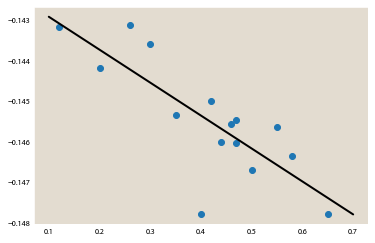

In [34]:
# Put all the plotting E. coli conditions into one dataframe.
coli_schmidt_all_conds = pd.concat([coli_schmidt_chemostat, coli_schmidt_batch])

# What is the relationship between growth rate and Z_C?
schmidt_lambda_ZCP_regression = linregress(coli_schmidt_all_conds.growth_rate_hr, coli_schmidt_all_conds.proteome_NOSC)
print(schmidt_lambda_ZCP_regression)

# plot the data
plt.plot(coli_schmidt_all_conds.growth_rate_hr, coli_schmidt_all_conds.proteome_NOSC, 'o')
# plot the regression line
xs = np.linspace(0.1, 0.7, 100)
pred_ys = schmidt_lambda_ZCP_regression.intercept + schmidt_lambda_ZCP_regression.slope * xs
plt.plot(xs, pred_ys, 'k-')
plt.show()

In [4]:
# Load biomass macromolecular composition from Bremer & Dennis 2008
bd_biomass_df = pd.read_excel('../data/physiology/BremerDennis_EcoSalPlus_2008.xlsx', index_col=0).T

# Calculate percent of biomass composition for RNA, protein and DNA as a function of growth rate.
cols = ['protein_ug_per_cell',
        'RNA_ug_per_cell',
        'DNA_ug_per_cell']
locs = [v for v in bd_biomass_df.index.values
        if v.startswith('u_')]

# Extract only the rows/columns we want
biomass_composition_df = bd_biomass_df[cols].loc[locs].copy()

# Get the total mass per cell from the parent DF
total_ug_per_cell = bd_biomass_df.loc[locs, 'mass_ug_per_cell']

# Extract the growth rate from the index
biomass_composition_df['growth_rate_hr'] = [float(v.strip('u_')) for v in biomass_composition_df.index.values]

# Calculate the mass fractions
biomass_percent_df = biomass_composition_df.copy()
biomass_percent_df[cols] = biomass_percent_df[cols].divide(total_ug_per_cell, axis=0)
biomass_percent_df[cols] = biomass_percent_df[cols].multiply(100) # pct
biomass_percent_df.columns = [c.replace('_ug_per_cell', '_percent') for c in biomass_percent_df.columns]
biomass_percent_df

,protein_percent,RNA_percent,DNA_percent,growth_rate_hr
u_0.6,60.176991,10.176991,3.362832,0.6
u_1.0,57.219251,11.764706,2.540107,1.0
u_1.5,53.153153,13.693694,2.162162,1.5
u_2.0,50.0,16.537468,1.899225,2.0
u_2.5,46.79696,19.543974,1.867535,2.5
u_3.0,41.642229,20.918866,1.896383,3.0


LinregressResult(slope=0.05022640357400159, intercept=-0.013298667106692377, rvalue=0.9961598304334474, pvalue=2.2092038147109205e-05, stderr=0.0022072215000601544, intercept_stderr=0.004308324490883772)


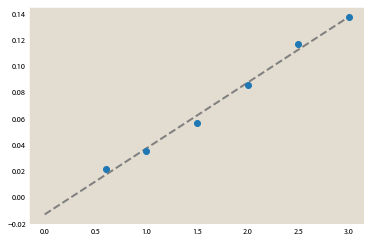

In [53]:
# Estimate ZC changes
# TODO: need to account for the slightly different carbon content of RNA, DNA and protein
cols = ['protein_percent', 'RNA_percent', 'DNA_percent']
ZCs = [-0.15, 0.9, 0.6]
inferred_ZCBs = (biomass_percent_df[cols]*ZCs/100).sum(axis=1)

reg_xs = biomass_percent_df.growth_rate_hr.values.astype(float)
reg_ys = inferred_ZCBs.values.astype(float)
lambda_ZCB_regression = linregress(reg_xs, reg_ys)
print(lambda_ZCB_regression)

# Peek at the results
lams = np.linspace(0, 3.0, 100)
plt.plot(lams, lambda_ZCB_regression.intercept + lambda_ZCB_regression.slope*lams, ls='--', color='grey')
plt.plot(biomass_percent_df.growth_rate_hr, inferred_ZCBs, 'o')


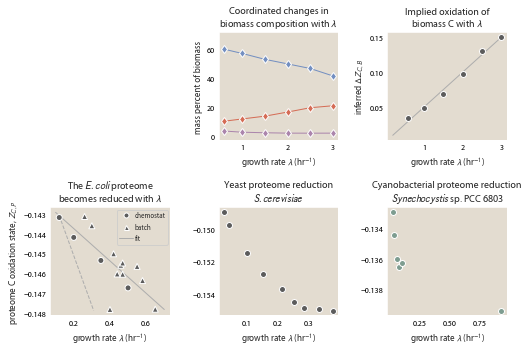

In [54]:
##### Figure 1 -- proteins expressed during faster growth are more reduced
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(7.24,5))
pal = sns.color_palette()
greys = sns.color_palette('Greys')

# Clear the first subplot
axs[0,0].axis('off')

# Top panels: expectations from E. coli physiology.
# Dependence of biomass fractional composition on growth rate -- 
# from Bremer and Dennis 2008 reprinted from earlier work. 
plt.sca(axs[0,1])
labels = 'protein,RNA,DNA'.split(',')
keys = ['{0}_percent'.format(l) for l in labels]

# Plot the fractional composition of biomass.
pal = [colors[cid] for cid in "blue,red,purple".split(",")]
for l,k,c in zip(labels, keys, pal):  
    ys = biomass_percent_df[k]
    plt.plot(biomass_percent_df.growth_rate_hr, ys, marker='d', label=l,
             markersize=6, markeredgecolor='w', lw=1, color=c)

plt.xlabel('growth rate $\lambda$ (hr$^{-1}$)')
plt.ylabel('mass percent of biomass')
plt.title('Coordinated changes in\nbiomass composition with $\lambda$')
plt.tick_params(axis='both')
plt.legend(loc=1).set_visible(False)
plt.ylim(-3, 72)

plt.sca(axs[0,2])
lams = np.linspace(0.2, 3.0, 100)
# Estimate ZC changes relative to lambda = 0, i.e. the intercept of the regression
dZCB = lambda_ZCB_regression.slope*lams
plt.plot(lams, dZCB, ls='-', color=greys[2], lw=1)
plt.plot(biomass_percent_df.growth_rate_hr, inferred_ZCBs - lambda_ZCB_regression.intercept, 'o',
         color=greys[-2], markeredgecolor='w', markersize=6, lw=1)
plt.xlabel('growth rate $\lambda$ (hr$^{-1}$)')
plt.ylabel('inferred $\Delta Z_{C,B}$')
plt.title('Implied oxidation of\nbiomass C with $\lambda$')

# E. coli proteomes from Schmidt 2016
plt.sca(axs[1,0])

# Plot expectations from biomass composition
# We assume a diffuse mechanism where every component of the biomass is 
# as likely to be compensatorily reduced as any other component. Hence
# the factor of -0.5 applied to the slope: protein is about 1/2 of biomass.
min_lambda = coli_schmidt_chemostat.growth_rate_hr.min()
min_fit_zcp = schmidt_lambda_ZCP_regression.intercept + schmidt_lambda_ZCP_regression.slope*min_lambda
lams = np.linspace(min_lambda, 0.31, 10)
expected_ZCP = (-0.5)*lambda_ZCB_regression.slope*(lams-min_lambda) + min_fit_zcp
plt.plot(lams, expected_ZCP, ls='--', color=greys[2], lw=1, zorder=-10)

# Plot the regression line for the E. coli data
lams = np.linspace(0.1, 0.7, 10)
fit_ZCPs = schmidt_lambda_ZCP_regression.intercept + schmidt_lambda_ZCP_regression.slope*lams
plt.plot(lams, fit_ZCPs, ls='-', color=greys[2], lw=1, zorder=-10)

# Plot the data
sns.scatterplot(data=coli_schmidt_chemostat, x='growth_rate_hr', y='proteome_NOSC',
                style='dataset', markers='o', edgecolor='w', color=greys[-2], linewidth=1,
                legend=False)
n_conds_batch = coli_schmidt_batch.condition.unique().size
sns.scatterplot(data=coli_schmidt_batch, x='growth_rate_hr', y='proteome_NOSC',
                style='dataset', markers='^', edgecolor='w', color=greys[-2], linewidth=1,
                legend=False)

plt.title('The $E. coli$ proteome\nbecomes reduced with $\lambda$')
plt.ylabel('proteome C oxidation state, $Z_{C,P}$')
plt.xlabel('growth rate $\lambda$ (hr$^{-1}$)')

legend_elements = [Line2D([0], [0], marker='o', color=AX_FACECOLOR, label='chemostat',
                          markerfacecolor=greys[-2], markeredgecolor='w',
                          linewidth=1, markersize=5),
                   Line2D([0], [0], marker='^', color=AX_FACECOLOR, label='batch',
                          markerfacecolor=greys[-2], markeredgecolor='w',
                          linewidth=1, markersize=5),
                   Line2D([0], [0], color=greys[2], label='fit', linewidth=1)]
plt.gca().legend(handles=legend_elements, loc=1,
                 handletextpad=0.2, borderaxespad=0.3, borderpad=0.3)


# S. cerevisiae proteome data from Xia 2016
plt.sca(axs[1,1])
sns.scatterplot(data=yeast_data, x='growth_rate_hr', y='proteome_NOSC',
                edgecolor='w', color=greys[-2], linewidth=1)
plt.title('Yeast proteome reduction\n$S. cerevisiae$')
plt.xlabel('growth rate $\lambda$ (hr$^{-1}$)')
plt.ylabel('')

# Cyanobacterial proteome data from Zavrel 2019
plt.sca(axs[1,2])
# Color by light intensity
n_intensities = cyano_data.red_light_intensity_uE_m_s.unique().size
sns.scatterplot(data=cyano_data, x='growth_rate_hr', y='proteome_NOSC',
                edgecolor='w', linewidth=1, color=colors['dark_green'],
                legend=False)
plt.title('Cyanobacterial proteome reduction\n$Synechocystis$ sp. PCC 6803')
plt.ylabel('')
plt.xlabel('growth rate $\lambda$ (hr$^{-1}$)')
plt.xticks([0.25, 0.5, 0.75])

plt.tight_layout()
plt.savefig('../output/Fig5.png', facecolor='w', dpi=300, bbox_inches='tight')
plt.show()

In [50]:
coli_exp = all_expression_data[all_expression_data.dataset == 'schmidt_2016']

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(5, 5))
axs = axs.flatten()
for i, (idx, gdf) in enumerate(coli_exp.groupby('dataset,condition'.split(','))):
    plt.hist(gdf.)

('schmidt_2016', '42C') (2040, 26)
('schmidt_2016', 'acetate') (2040, 26)
('schmidt_2016', 'chemostat_u0.12') (2040, 26)
('schmidt_2016', 'chemostat_u0.2') (2040, 26)
('schmidt_2016', 'chemostat_u0.35') (2040, 26)
('schmidt_2016', 'chemostat_u0.5') (2040, 26)
('schmidt_2016', 'fructose') (2040, 26)
('schmidt_2016', 'fumarate') (2040, 26)
('schmidt_2016', 'galactose') (2040, 26)
('schmidt_2016', 'glucosamine') (2040, 26)
('schmidt_2016', 'glucose') (2040, 26)
('schmidt_2016', 'glycerol') (2040, 26)
('schmidt_2016', 'glycerol_pAA') (2040, 26)
('schmidt_2016', 'lb_miller') (2040, 26)
('schmidt_2016', 'mannose') (2040, 26)
('schmidt_2016', 'osmotic_stress_glucose') (2040, 26)
('schmidt_2016', 'pH6') (2040, 26)
('schmidt_2016', 'pyruvate') (2040, 26)
('schmidt_2016', 'succinate') (2040, 26)
('schmidt_2016', 'xylose') (2040, 26)


In [52]:
coli_exp

,b_number,dataset,strain,condition,growth_rate_hr,copies_per_cell,fg_per_cell,NOSC,NC_per,num_aas,...,growth_mode,stress,Ce_per,Ce_total,NC_total,gene_name,sample_name,Unnamed: 0,red_light_intensity_uE_m_s,C_fraction
22,b3448,schmidt_2016,BW25113,42C,0.66,272.268322,0.007513,-0.031204,706.0,146.0,...,batch,True,-22.03,-5998.071131,192221.435245,NaN,NaN,NaN,NaN,0.000029
23,b3448,schmidt_2016,BW25113,acetate,0.30,147.015607,0.004057,-0.031204,706.0,146.0,...,batch,False,-22.03,-3238.753814,103793.018272,NaN,NaN,NaN,NaN,0.000022
24,b3448,schmidt_2016,BW25113,chemostat_u0.12,0.12,182.004991,0.005023,-0.031204,706.0,146.0,...,chemostat,False,-22.03,-4009.569943,128495.523358,NaN,NaN,NaN,NaN,0.000031
25,b3448,schmidt_2016,BW25113,chemostat_u0.2,0.20,137.023553,0.003781,-0.031204,706.0,146.0,...,chemostat,False,-22.03,-3018.628866,96738.628197,NaN,NaN,NaN,NaN,0.000022
26,b3448,schmidt_2016,BW25113,chemostat_u0.35,0.35,141.887995,0.003916,-0.031204,706.0,146.0,...,chemostat,False,-22.03,-3125.792538,100172.924724,NaN,NaN,NaN,NaN,0.000020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85687,b3955,schmidt_2016,BW25113,osmotic_stress_glucose,0.55,34.374261,0.003801,-0.172773,3058.0,577.0,...,batch,True,-528.34,-18161.297275,105116.491403,NaN,NaN,NaN,NaN,0.000017
85688,b3955,schmidt_2016,BW25113,pH6,0.63,32.228370,0.003564,-0.172773,3058.0,577.0,...,batch,True,-528.34,-17027.536932,98554.355034,NaN,NaN,NaN,NaN,0.000015
85689,b3955,schmidt_2016,BW25113,pyruvate,0.40,27.895161,0.003084,-0.172773,3058.0,577.0,...,batch,False,-528.34,-14738.129121,85303.400940,NaN,NaN,NaN,NaN,0.000016
85690,b3955,schmidt_2016,BW25113,succinate,0.44,36.451638,0.004031,-0.172773,3058.0,577.0,...,batch,False,-528.34,-19258.858165,111469.107523,NaN,NaN,NaN,NaN,0.000020
